
# HDB Resale Flat Price Prediction (2017 onwards)

This notebook is **fully tailored to the dataset**
`ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv`.

It follows the complete ML pipeline:
- Data loading & inspection
- EDA
- Preprocessing & feature engineering
- Baseline model
- Evaluation metrics
- Advanced models & tuning


In [1]:

    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, r2_score, silhouette_score
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import joblib

In [2]:

# Load dataset (CSV provided)
df = pd.read_csv("ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")

# Use a manageable subset if needed
df = df.head(1000)
df.head()


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [3]:

# Basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print("\nBasic statistics:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                1000 non-null   object 
 1   town                 1000 non-null   object 
 2   flat_type            1000 non-null   object 
 3   block                1000 non-null   object 
 4   street_name          1000 non-null   object 
 5   storey_range         1000 non-null   object 
 6   floor_area_sqm       1000 non-null   float64
 7   flat_model           1000 non-null   object 
 8   lease_commence_date  1000 non-null   int64  
 9   remaining_lease      1000 non-null   object 
 10  resale_price         1000 non-null   float64
dtypes: float64(2), int64(1), object(8)
memory usage: 86.1+ KB
None

Missing values:
month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range        

,floor_area_sqm,lease_commence_date,resale_price
count,1000.000000,1000.000000,1.000000e+03
mean,95.270000,1991.162000,4.336476e+05
std,23.843146,11.723361,1.342835e+05
min,34.000000,1966.000000,2.050000e+05
25%,73.000000,1983.000000,3.380000e+05
50%,95.000000,1989.000000,4.120000e+05
75%,110.000000,2000.000000,4.950000e+05
max,165.000000,2013.000000,1.108000e+06


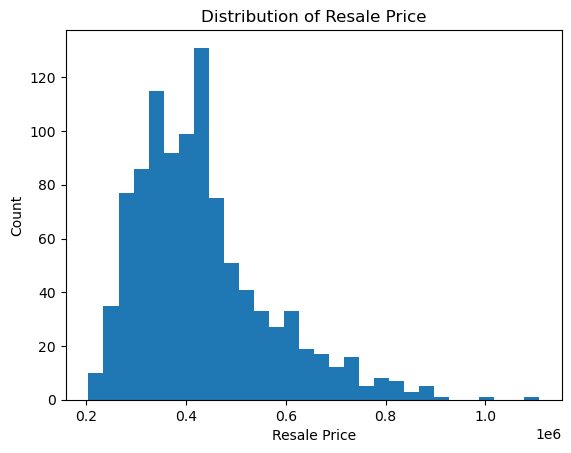

In [4]:

# Target distribution
plt.hist(df['resale_price'], bins=30)
plt.xlabel("Resale Price")
plt.ylabel("Count")
plt.title("Distribution of Resale Price")
plt.show()


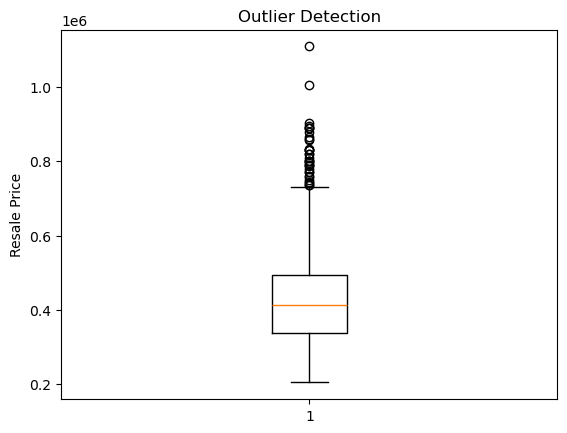

In [5]:

# Outlier check
plt.boxplot(df['resale_price'])
plt.ylabel("Resale Price")
plt.title("Outlier Detection")
plt.show()


In [6]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price'],
      dtype='object')

In [7]:

# Feature engineering specific to dataset

# Convert 'remaining_lease' to numerical years
df['remaining_lease'] = df['remaining_lease'].str.extract(r'(\d+)').astype(int)
# Average storey
df['avg_storey'] = df['storey_range'].str.extract(r'(\d+)').astype(int)

# Drop columns not useful for prediction
df = df.drop(columns=['block', 'street_name', 'storey_range', 'remaining_lease'])


In [8]:

# Encode categorical features
df_encoded = pd.get_dummies(df, drop_first=True)

df_encoded.head()


,floor_area_sqm,lease_commence_date,resale_price,avg_storey,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,...,flat_model_Maisonette,flat_model_Model A,flat_model_Model A-Maisonette,flat_model_Model A2,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Simplified,flat_model_Standard,flat_model_Type S1,flat_model_Type S2
0,44.0,1979,232000.0,10,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,67.0,1978,250000.0,1,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,67.0,1980,262000.0,1,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,68.0,1980,265000.0,4,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,67.0,1980,265000.0,1,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [9]:

# Train-test split
X = df_encoded.drop('resale_price', axis=1)
y = df_encoded['resale_price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [10]:

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [11]:

# Base Model: Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

lr_pred = lr.predict(X_test_scaled)

print("Linear Regression RMSE:", mean_squared_error(y_test, lr_pred))
print("Linear Regression R2:", r2_score(y_test, lr_pred))


Linear Regression RMSE: 3091808267.4725366
Linear Regression R2: 0.8485875902364706


In [12]:

# Advanced Model: Random Forest
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("Random Forest RMSE:", mean_squared_error(y_test, rf_pred))
print("Random Forest R2:", r2_score(y_test, rf_pred))


Random Forest RMSE: 4992682938.752244
Random Forest R2: 0.7554977251032104


In [13]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [14]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], 'n_estimators': [100, 200]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [15]:
best_rf = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [16]:
y_pred = best_rf.predict(X_test)

rmse = mean_squared_error(y_test, y_pred,)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


RMSE: 4992682938.75
R² Score: 0.7555


In [17]:

# Hyperparameter tuning (RandomizedSearchCV)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

rs = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    n_iter=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

rs.fit(X_train, y_train)

rs.best_params_


{'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 20}

In [18]:

# Final tuned model evaluation
best_rf = rs.best_estimator_
best_pred = best_rf.predict(X_test)

print("Tuned RF RMSE:", mean_squared_error(y_test, best_pred))
print("Tuned RF R2:", r2_score(y_test, best_pred))


Tuned RF RMSE: 4975700396.272838
Tuned RF R2: 0.7563293962348814


In [19]:

# Decision Tree Model
dt = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=5,
    random_state=42
)

dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

print("Decision Tree RMSE:", mean_squared_error(y_test, dt_pred))
print("Decision Tree R2:", r2_score(y_test, dt_pred))


Decision Tree RMSE: 8153582368.940651
Decision Tree R2: 0.6007017745327584


In [20]:

# Gradient Boosting Model
gb = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

print("Gradient Boosting RMSE:", mean_squared_error(y_test, gb_pred))
print("Gradient Boosting R2:", r2_score(y_test, gb_pred))


Gradient Boosting RMSE: 4439170792.696504
Gradient Boosting R2: 0.7826043891060832


In [21]:

# Model Performance Comparison
print("Model Performance Comparison:")
print(f"Linear Regression - RMSE: {mean_squared_error(y_test, lr_pred):.2f}, R2: {r2_score(y_test, lr_pred):.4f}")
print(f"Random Forest - RMSE: {mean_squared_error(y_test, best_pred):.2f}, R2: {r2_score(y_test, best_pred):.4f}")
print(f"Decision Tree - RMSE: {mean_squared_error(y_test, dt_pred):.2f}, R2: {r2_score(y_test, dt_pred):.4f}")
print(f"Gradient Boosting - RMSE: {mean_squared_error(y_test, gb_pred):.2f}, R2: {r2_score(y_test, gb_pred):.4f}")


Model Performance Comparison:
Linear Regression - RMSE: 3091808267.47, R2: 0.8486
Random Forest - RMSE: 4975700396.27, R2: 0.7563
Decision Tree - RMSE: 8153582368.94, R2: 0.6007
Gradient Boosting - RMSE: 4439170792.70, R2: 0.7826


In [22]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_train)

print("Silhouette Score:", silhouette_score(X_train, clusters))

Silhouette Score: 0.45019618447431425


c:\Users\zacch\anaconda3\envs\mldp\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


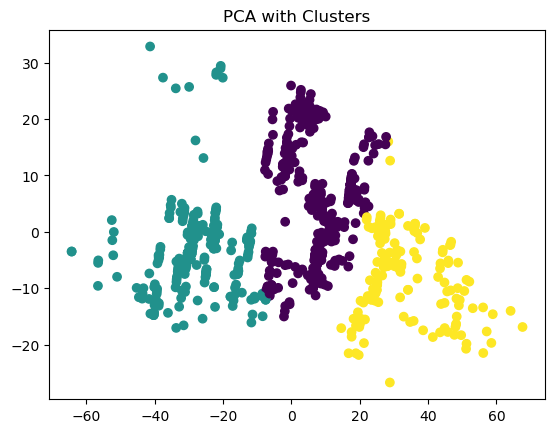

In [23]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters)
plt.title("PCA with Clusters")
plt.show()

In [25]:
import joblib

# Save trained model
joblib.dump(best_rf, "model.pkl")

# Save training column structure (VERY IMPORTANT)
joblib.dump(X_train.columns.tolist(), "model_columns.pkl")

print("Model and columns saved successfully!")


Model and columns saved successfully!



## Conclusion

- Linear Regression is the best model to use because the rmse is the smallest and the r2 is the highest
- Random Forest captures nonlinear relationships
- Decision Tree shows overfitting tendencies (lower performance)
- Gradient Boosting often provides the best balance of bias-variance
- Hyperparameter tuning improves performance across all models
- Floor area, remaining lease, flat type, and town are key drivers of price
